In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget

In [3]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl

In [4]:
tqdm.pandas()

In [5]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 9
buffered = True
edges = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_drive_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
edges.tail(5)

,id,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,...,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector,geometry
14667,9678,891e2040c67ffff,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
14668,9679,891e2040c67ffff,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
14669,9680,891e204e093ffff,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
14670,9681,891e20462c3ffff,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."
14671,9682,891e20471d3ffff,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.12107 51.14465, 17.12089 51.144..."


In [6]:
hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON").set_index("h3_id")
hexagons.head(5)

,coordinates,parent,children,resolution,geometry
h3_id,,,,,
891e2045463ffff,"(51.09545580515501, 17.10268480221783)",881e204547fffff,"{'8a1e20454617fff', '8a1e20454627fff', '8a1e20...",9,"POLYGON ((17.10016 51.09622, 17.10019 51.09454..."
891e20456b3ffff,"(51.09256633045563, 17.090199278402874)",881e20456bfffff,"{'8a1e20456b27fff', '8a1e20456b37fff', '8a1e20...",9,"POLYGON ((17.08767 51.09333, 17.08771 51.09165..."
891e2041837ffff,"(51.06389906779957, 16.975441510431143)",881e204183fffff,"{'8a1e2041834ffff', '8a1e2041835ffff', '8a1e20...",9,"POLYGON ((16.97292 51.06466, 16.97295 51.06298..."
891e2042d23ffff,"(51.169360089031485, 17.04090812166009)",881e2042d3fffff,"{'8a1e2042d227fff', '8a1e2042d207fff', '8a1e20...",9,"POLYGON ((17.03838 51.17013, 17.03842 51.16845..."
891e2041d0bffff,"(51.07904535087956, 16.97510694306701)",881e2041d1fffff,"{'8a1e2041d0b7fff', '8a1e2041d0affff', '8a1e20...",9,"POLYGON ((16.97258 51.07981, 16.97262 51.07813..."


In [7]:
edges_shp = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, "shp_drive", f"edges_hex_{get_resolution_buffered_suffix(resolution, buffered)}.shp")).set_index("h3_id")

In [8]:
edges.columns

Index(['id', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2', 'lanes_3',
       'lanes_4', 'lanes_5', 'lanes_6',
       ...
       'width_24.5', 'width_25.5', 'width_26.5', 'width_27.5', 'width_28.5',
       'width_29.5', 'tunnel_building_passage', 'tunnel_yes',
       'tunnel_avalanche_protector', 'geometry'],
      dtype='object', length=130)

In [9]:
hex_feautres = edges.drop(columns="id").groupby(by="h3_id").sum()
hex_feautres

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,5,0,0,2,1,0,0,0,0,2,...,0,0,0,0,0,0,0,1,0,0
891e2040013ffff,4,2,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
891e2040017ffff,8,4,0,2,1,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
891e2040023ffff,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2040027ffff,8,5,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b73ffff,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b77ffff,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
hex_features_tfidf = tfidf(hex_feautres)
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,width_23.5,width_24.5,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,0.470615,0.000000,0.000000,0.300719,0.211734,0.0,0.0,0.0,0.0,0.436089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471141,0.0,0.0
891e2040013ffff,0.207013,0.196128,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.479564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2040017ffff,0.450436,0.426753,0.000000,0.179891,0.126659,0.0,0.0,0.0,0.0,0.391304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2040023ffff,0.522938,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2040027ffff,0.312260,0.369802,0.101102,0.249415,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,0.637404,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2055b73ffff,0.640997,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
891e2055b77ffff,0.640997,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [48]:
embedding = reduce_umap(hex_features_tfidf, n_components=2, n_neighbors=7, metric="cosine")[0]

In [50]:
embedding["cluster"] = cluster_hdbscan(embedding, min_cluster_size=30, metric="euclidean")[0]
fig = px.scatter(embedding, x="x_0", y="x_1", color="cluster", width=800, height=700)
fig.show()

In [51]:
embedding.index = hex_feautres.index
embedding.head(5)

,x_0,x_1,cluster
h3_id,,,
891e2040007ffff,12.705469,5.248577,7
891e2040013ffff,10.511019,4.871730,8
891e2040017ffff,9.731228,4.316377,8
891e2040023ffff,5.498260,3.341390,14
891e2040027ffff,10.365551,7.170233,6


In [52]:
hexagons_clustered = hexagons.join(embedding).dropna()
hexagons_clustered.head(5)

,coordinates,parent,children,resolution,geometry,x_0,x_1,cluster
h3_id,,,,,,,,
891e20456b3ffff,"(51.09256633045563, 17.090199278402874)",881e20456bfffff,"{'8a1e20456b27fff', '8a1e20456b37fff', '8a1e20...",9,"POLYGON ((17.08767 51.09333, 17.08771 51.09165...",12.847746,-6.341022,-1
891e2041837ffff,"(51.06389906779957, 16.975441510431143)",881e204183fffff,"{'8a1e2041834ffff', '8a1e2041835ffff', '8a1e20...",9,"POLYGON ((16.97292 51.06466, 16.97295 51.06298...",13.581808,8.986872,10
891e2041d0bffff,"(51.07904535087956, 16.97510694306701)",881e2041d1fffff,"{'8a1e2041d0b7fff', '8a1e2041d0affff', '8a1e20...",9,"POLYGON ((16.97258 51.07981, 16.97262 51.07813...",7.637547,4.087936,8
891e2041917ffff,"(51.06710228802962, 16.997936991090988)",881e204191fffff,"{'8a1e20419177fff', '8a1e2041916ffff', '8a1e20...",9,"POLYGON ((16.99541 51.06787, 16.99545 51.06619...",7.014167,-3.334807,13
891e20432abffff,"(51.11540773315221, 16.84385069938052)",881e20432bfffff,"{'8a1e20432a97fff', '8a1e20432a9ffff', '8a1e20...",9,"POLYGON ((16.84132 51.11617, 16.84136 51.11449...",1.243349,1.256092,14


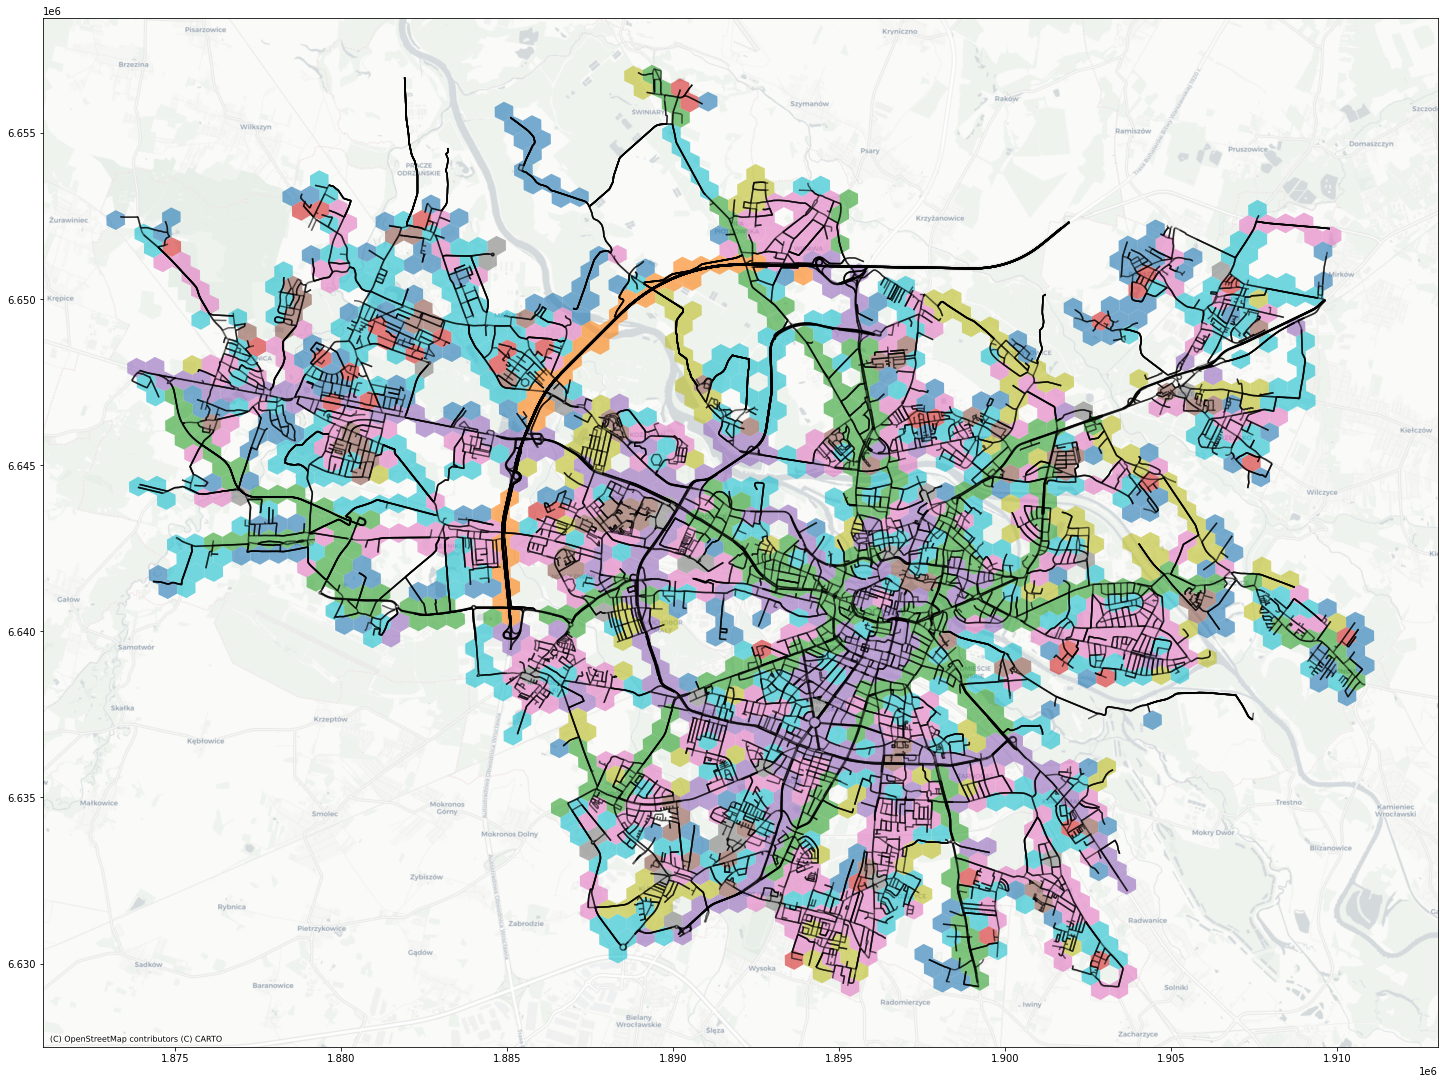

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(25, 23))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
edges.to_crs(epsg=3857).plot(ax=ax, color="black", alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [54]:
hex_group_cluster = hex_features_tfidf.join(embedding).groupby(by="cluster")

In [55]:
hex_agg = hex_group_cluster.mean().reset_index()
hex_agg

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,width_25.5,width_26.5,width_27.5,width_28.5,width_29.5,tunnel_building_passage,tunnel_yes,tunnel_avalanche_protector,x_0,x_1
0,-1,0.296465,0.100783,0.102842,0.064731,0.052916,0.006878,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,10.432105,5.360018
1,0,0.640553,0.001737,0.000000,0.001499,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,28.399412,9.880854
2,1,0.097279,0.228395,0.009325,0.074775,0.255150,0.306295,0.000000,0.000000,0.021397,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,21.418476,-7.257726
3,2,0.201190,0.242351,0.007303,0.331563,0.077292,0.016987,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.955404,12.980012
4,3,0.288715,0.246344,0.061961,0.231008,0.135447,0.105077,0.009212,0.001835,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.003576,0.002322,0.0,5.866488,9.057062
5,4,0.643723,0.006051,0.000000,0.038223,0.005968,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,14.095086,1.579518
6,5,0.170588,0.301656,0.074495,0.262219,0.152348,0.067046,0.016831,0.000000,0.000722,...,0.0,0.0,0.0,0.0,0.0,0.009592,0.002438,0.0,16.157343,6.384426
7,6,0.183601,0.422394,0.204885,0.320375,0.107797,0.061543,0.004880,0.002395,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.008015,0.0,10.522411,7.588794
8,7,0.458397,0.088647,0.038214,0.108921,0.017063,0.003230,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.028751,0.009072,0.0,12.683182,4.705358
9,8,0.463869,0.045019,0.011915,0.152097,0.016992,0.006094,0.002137,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.004541,0.003253,0.0,8.936244,2.986307


In [56]:
fig = px.bar(hex_agg, x="cluster", y=list(filter(lambda x: "bridge" in x, hex_agg.columns)), width=1300)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
    )
)
fig.show()

In [61]:
from src.tools.feature_extraction import melt_and_max

for column_name in ["oneway", "lanes", "maxspeed", "width"]:
    columns = [x for x in edges.columns if column_name in x]
    edges = edges.join(melt_and_max(edges, column_name, columns), on="id")
edges

ValueError: columns overlap but no suffix specified: Index(['oneway'], dtype='object')

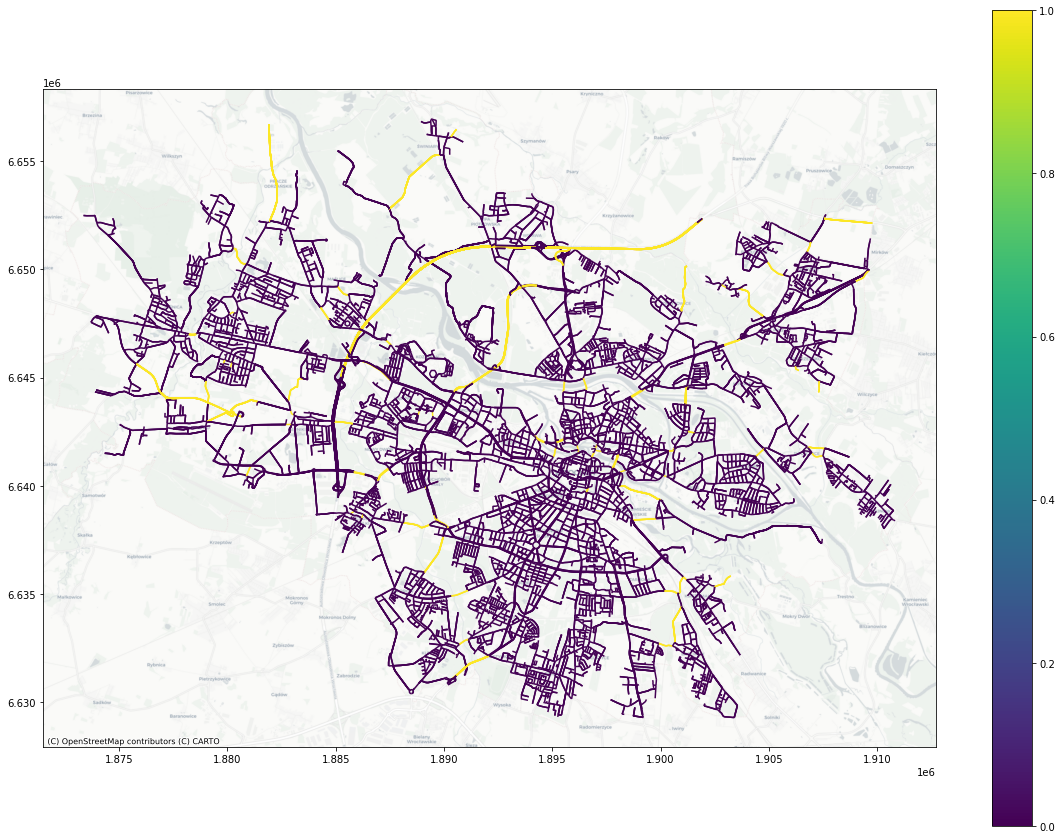

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
# hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
edges.to_crs(epsg=3857).plot(ax=ax, column="bridge_yes", alpha=1, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [64]:
m = KeplerGl()
m.add_data(edges.copy(), name="hexagons")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'hexagons': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…